In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer


from digitech_classify.pipeline.config import DATA_DIR, PROCESSED_DATA_DIR
from digitech_classify.pipeline.data_engineering.features import batch_lemmatize, nlp_fast


In [2]:
df = pd.read_excel(DATA_DIR / "human_QA/" / "training_multilabels_agg.xlsx")

y_train = df["all_sectors"]   


In [3]:
parsed_labels = y_train.apply(lambda x: list(ast.literal_eval(x)))
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(parsed_labels)


In [4]:
print("Encoded labels shape:", y_encoded.shape)
print("Classes:", mlb.classes_)

Encoded labels shape: (25280, 12)
Classes: ['advanced digital communications and connectivity'
 'artificial intelligence' 'blockchain' 'cloud-edge-iot' 'cybersecurity'
 'data analytics' 'high performance computing'
 'microelectronics and semiconductors'
 'next generation internet and extended reality' 'photonics'
 'quantum technologies' 'robotics']


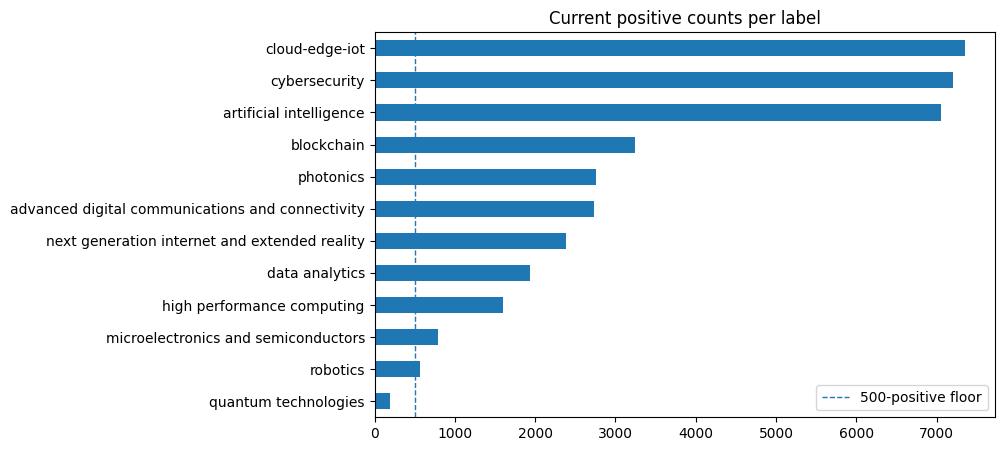

In [5]:

label_counts = pd.Series(y_encoded.sum(axis=0), index=mlb.classes_).sort_values(ascending=False)

# bar plot + threshold
ax = label_counts.plot(kind='barh', figsize=(8,5))
ax.axvline(500, ls='--', lw=1, label='500-positive floor')
plt.legend()
plt.gca().invert_yaxis()
plt.title('Current positive counts per label')
plt.show()


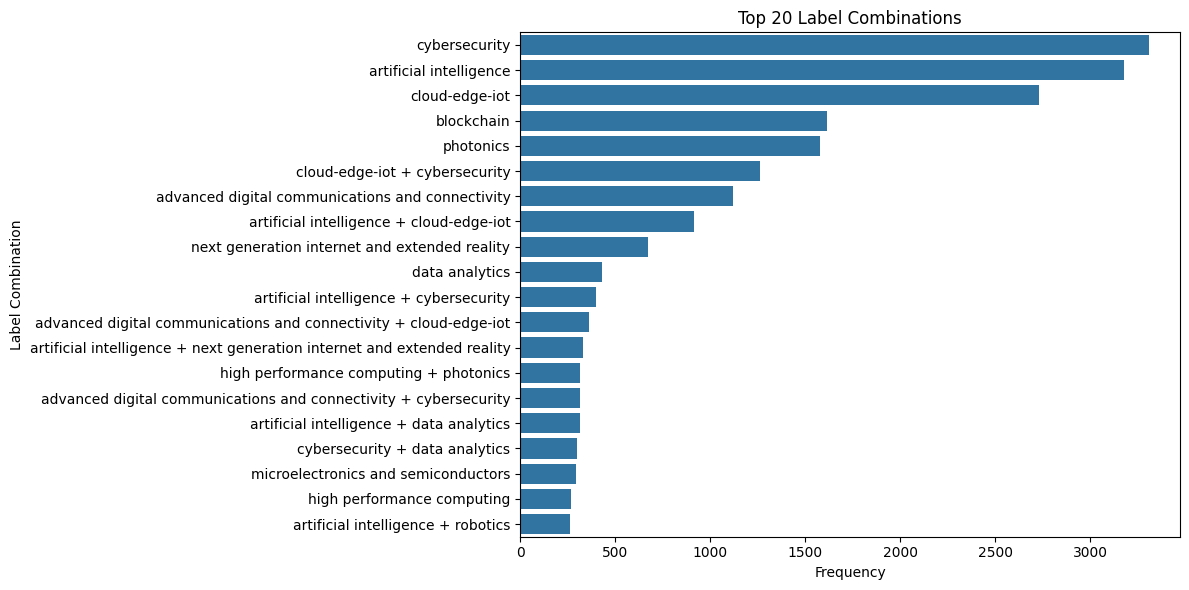

In [6]:
label_combos = []
for row in y_encoded:
    present = [label for label, present in zip(mlb.classes_, row) if present]
    label_combos.append(tuple(sorted(present)))

combo_counts = Counter(label_combos)
top_combos = combo_counts.most_common(20)

combo_labels = [' + '.join(c) if c else 'NO LABELS' for c, _ in top_combos]
combo_freqs = [f for _, f in top_combos]

plt.figure(figsize=(12, 6))
sns.barplot(x=combo_freqs, y=combo_labels, orient='h')
plt.title('Top 20 Label Combinations')
plt.xlabel('Frequency')
plt.ylabel('Label Combination')
plt.tight_layout()
plt.show()

In [7]:
companies_df = pd.read_csv(PROCESSED_DATA_DIR / "company_tagged_all-MiniLM-L6-v2.csv")
print("Companies DataFrame shape:", companies_df.shape)
print("Unique labels in 'keyword':", companies_df['keyword'].nunique())


Companies DataFrame shape: (107335, 5)
Unique labels in 'keyword': 1627


In [8]:
kw_df = pd.read_excel(DATA_DIR / "keywords_combined_digital/Keywords_Combined.xlsx", sheet_name="Sheet1")
kw_df['Keyword'] = kw_df['Keyword'].astype(str).str.strip().str.lower()
kw_df = kw_df[kw_df['yes/no'] == 'yes']
kw_df = kw_df.drop(columns=['yes/no', 'Subcluster', 'Cluster'])
kw_df['Sector'] = kw_df['Sector'].astype(str).str.strip().str.lower()

kw_df['keywords_lemma'] = batch_lemmatize(
    kw_df['Keyword'].tolist(), model=nlp_fast, batch_size=5000
)

Processing texts: 100%|██████████| 2057/2057 [00:00<00:00, 9065.94it/s] 


In [9]:
# Merge companies_df with kw_df to add sector information
companies_df = companies_df.merge(
    kw_df[['keywords_lemma', 'Sector']], 
    left_on='keyword', 
    right_on='keywords_lemma', 
    how='left'
)

# Drop the redundant keywords_lemma column
companies_df = companies_df.drop(columns=['keywords_lemma'])


In [10]:
quantum_df = companies_df[
    (companies_df['similarity'] >= 0.65) & 
    (companies_df['Sector'].str.contains('quantum technologies', case=False, na=False))
]


print(quantum_df.head())

                                    org_ID  \
482   1b923b7c-b415-a83c-cbcc-53b27c877907   
968   bc9c7b68-1f77-2d0f-1b00-60badc1b53e9   
2586  c6bc5463-c24a-b64f-7572-0f2c7e9e3345   
2718  23b8bf29-aa47-fb40-045f-d85cad1aea04   
2737  cdb0dd13-39cb-5120-c606-7519fa8a1641   

                                 keyword  similarity  \
482                     nano fabrication    0.721284   
968   quantum computing platform service    0.725129   
2586                    nano fabrication    0.720286   
2718                    nano fabrication    0.679409   
2737                    nano fabrication    0.693334   

                                      organisation_name  \
482                                             NanoInk   
968                                      Quantum Coders   
2586  Nanotechnology Institute in Philadelphia Penns...   
2718                                     Nanoconduction   
2737                           NanoSurface Technologies   

                               

In [11]:
quantum_df = quantum_df.groupby('org_ID').agg({
    'organisation_name': 'first',
    'keyword': list,
    'similarity': list,
    'search_text': 'first'
}).reset_index()



In [12]:
HPC_df = companies_df[
    (companies_df['similarity'] >= 0.7) & 
    (companies_df['Sector'].str.contains('high performance computing', case=False, na=False))
]

HPC_df = HPC_df.groupby('org_ID').agg({
    'organisation_name': 'first',
    'keyword': list,
    'similarity': list,
    'search_text': 'first'
}).reset_index()



In [13]:
robotics_df = companies_df[
    (companies_df['similarity'] >= 0.7) & 
    (companies_df['Sector'].str.contains('robotics', case=False, na=False))
]

robotics_df = robotics_df.groupby('org_ID').agg({
    'organisation_name': 'first',
    'keyword': list,
    'similarity': list,
    'search_text': 'first'
}).reset_index()



In [14]:
robotics_df['sector'] = 'robotics'
HPC_df['sector'] = 'high performance computing'

In [15]:
# Add sector column to quantum_companies
quantum_df['sector'] = 'quantum technologies'

# Then combine all three sector dataframes
sector_companies = pd.concat([robotics_df, HPC_df, quantum_df], ignore_index=True)
print("Sector companies DataFrame shape:", sector_companies.shape)

Sector companies DataFrame shape: (723, 6)


In [16]:
# Add companies that are only in sector_companies but not in df
sector_companies = sector_companies[~sector_companies['org_ID'].isin(df['org_ID'])].copy()


In [17]:

# Create a DataFrame with the same structure as df for sector-only companies
sector_only_df = pd.DataFrame({
    'org_ID': sector_companies['org_ID'],
    'organisation_name': sector_companies['organisation_name'],
    'all_sectors': sector_companies['sector'],  # These companies don't have training labels
    'search_text': sector_companies['search_text'],
})
sector_only_df['all_sectors'] = sector_only_df['all_sectors'].apply(lambda x: {x})
# Combine the enriched df with sector-only companies
df_enriched = pd.concat([df, sector_only_df], ignore_index=True)


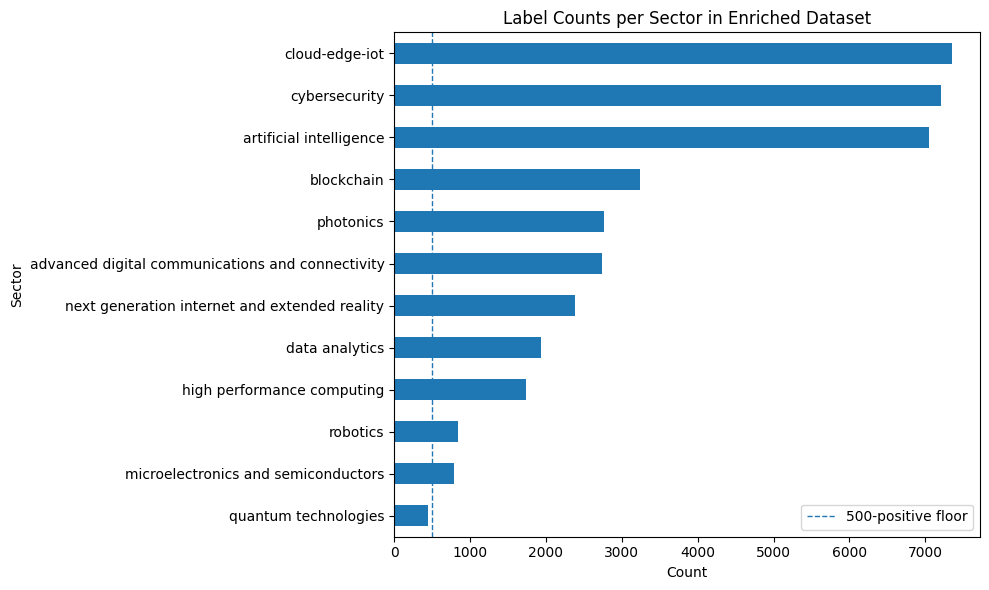

In [18]:
# Parse and encode labels for the enriched dataset
parsed_labels_enriched = df_enriched["all_sectors"].apply(lambda x: list(x) if isinstance(x, set) else list(ast.literal_eval(x)))
y_encoded_enriched = mlb.transform(parsed_labels_enriched)

# Calculate label counts for enriched dataset
label_counts_enriched = pd.Series(y_encoded_enriched.sum(axis=0), index=mlb.classes_).sort_values(ascending=False)

# Create bar plot for enriched dataset
ax = label_counts_enriched.plot(kind='barh', figsize=(10,6))
ax.axvline(500, ls='--', lw=1, label='500-positive floor')
plt.legend()
plt.gca().invert_yaxis()
plt.title('Label Counts per Sector in Enriched Dataset')
plt.xlabel('Count')
plt.ylabel('Sector')
plt.tight_layout()
plt.show()


In [19]:
save_path = PROCESSED_DATA_DIR / "multilabelled_training_set_enriched_v2.csv"
df_enriched.to_csv(save_path, index=False)